# **CARTOONIZATION**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at the provided path: {image_path}")
    return img

def resize_image(img, target_width=600):
    height, width = img.shape[:2]
    aspect_ratio = width / height
    target_height = int(target_width / aspect_ratio)
    return cv2.resize(img, (target_width, target_height))

def display_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()


In [3]:
def convert_to_grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.medianBlur(gray, 5)

def sharpen_image(img):
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1, 9, -1],
                               [-1, -1, -1]])
    return cv2.filter2D(img, -1, sharpen_kernel)

def detect_edges_canny(img_gray):
    edges = cv2.Canny(img_gray, threshold1=50, threshold2=150)
    return cv2.bitwise_not(edges)

def apply_bilateral_filter(img, no_of_filters=2):
    color = img.copy()
    for _ in range(no_of_filters):
        color = cv2.bilateralFilter(color, 9, 150, 150)  # Reduced smoothing
    return color

In [4]:
def blend_with_original(img, cartoon, alpha):
    return cv2.addWeighted(img, alpha, cartoon, 1 - alpha, 0)

def blend_edges_with_image(img, edges):
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    return cv2.addWeighted(img, 0.9, edges_colored, 0.1, 0)

def gamma_correction(img, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)


In [5]:
def cartoonize_image(img, edges):
    return cv2.bitwise_and(img, img, mask=edges)

In [6]:
def process_image(image_path):
    img = load_image(image_path)
    img_resized = resize_image(img)
    print("Original Image")
    display_image(img_resized)

    # Cartoonization Steps
    gray_img = convert_to_grayscale(img_resized)
    sharpened_img = sharpen_image(img_resized)

    edges = detect_edges_canny(gray_img)
    filtered_img = apply_bilateral_filter(sharpened_img)

    # Cartoonize and blend with the original image
    cartoon_img = cartoonize_image(filtered_img, edges)
    cartoon_with_original_colors = blend_with_original(img_resized, cartoon_img, alpha=0.25)
    blended_with_edges = blend_edges_with_image(cartoon_with_original_colors, edges)

    # Enhance details with gamma correction
    enhanced_cartoon = gamma_correction(blended_with_edges, gamma=0.85)

    # Display final cartoonized image
    print("Cartoon Image")
    display_image(enhanced_cartoon)

    return enhanced_cartoon

# **STYLE TRANSFER**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import os
import cv2

# STYLE ENCODER

In [77]:
def vgg_style_encoder():
    vgg = models.vgg19(pretrained=True).features

    style_layers = [ '6', '9','11', '13']
    style_features = nn.ModuleList([vgg[int(layer)] for layer in style_layers])

    content_features = nn.Sequential(*list(vgg.children())[:21])
    style_features = nn.Sequential(*style_features)

    for param in style_features.parameters():
        param.requires_grad = False
    for param in content_features.parameters():
        param.requires_grad = False

    return content_features, style_features

# CROSS FUSION ATTENTION

In [78]:
def cross_fusion_attention(high_level_features, low_level_features):
    gap = nn.AdaptiveAvgPool2d(1).cuda()
    high_level_features_gap = gap(high_level_features)

    low_level_features_gap = gap(low_level_features)

    conv = nn.Conv2d(high_level_features_gap.size(1), low_level_features_gap.size(1), kernel_size=1, padding = 1).cuda()
    fca = torch.sigmoid(conv(high_level_features_gap)) * low_level_features_gap


    conv_cross_attention = nn.Conv2d(fca.size(1), 512, kernel_size=1, stride=1, padding=1).cuda()
    bn_cross_attention = nn.BatchNorm2d(512).cuda()
    relu_cross_attention = nn.ReLU().cuda()
    cross_attention_features = relu_cross_attention(bn_cross_attention(conv_cross_attention(fca)))

    max_pool = nn.AdaptiveMaxPool2d(1).cuda()
    avg_pool = nn.AdaptiveAvgPool2d(1).cuda()
    max_pooled_features = max_pool(cross_attention_features)
    avg_pooled_features = avg_pool(cross_attention_features)

    combined_pooled_features =  torch.cat((max_pooled_features, avg_pooled_features), dim=1)



    sigmoid_output = torch.sigmoid(combined_pooled_features)
    conv_reduce_channels = nn.Conv2d(combined_pooled_features.size(1), max_pooled_features.size(1), kernel_size=1).cuda()
    sigmoid_output = conv_reduce_channels(sigmoid_output)

    # print(sigmoid_output.size())

    final_output = high_level_features_gap * sigmoid_output

    return final_output

# STYLE TRANSFER NET

In [79]:
def style_transfer_net():
    vgg = models.vgg19(pretrained=True).features.cuda()
    content_layers = list(vgg.children())[:21]
    content_encoder = nn.Sequential(*content_layers)

    decoder = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 3, kernel_size=3, padding=1),
        nn.Tanh()
    )
    for param in content_encoder.parameters():
        param.requires_grad = False


    return content_encoder, decoder

In [80]:
def discriminator():
    layers = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )
    return layers

In [81]:
def joint_loss_with_dft(alpha, beta, gamma, generated, content, style, disc):
    adversarial_loss = nn.BCEWithLogitsLoss()
    l1_loss = nn.L1Loss()

    real_score = torch.sigmoid(disc(style))
    fake_score = torch.sigmoid(disc(generated))
    loss_adv = torch.sum(torch.mean(torch.log(real_score))) + torch.sum(torch.mean(1 - torch.log( fake_score)))

    loss_l1 = l1_loss(generated, style)

    def frequency_loss(img1, img2):
        dft1 = torch.fft.fft2(img1)
        dft2 = torch.fft.fft2(img2)
        mag1 = torch.abs(dft1)
        mag2 = torch.abs(dft2)
        N,M = img1.shape[2], img1.shape[3]
        return (torch.sum(torch.abs(mag1 - mag2)**2))/(N*M)

    loss_dft = frequency_loss(generated, style)

    total_loss = alpha * loss_adv + beta * loss_l1 + gamma * loss_dft
    return total_loss

In [91]:
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def train_style_transfer_model(content_dataset_path, style_dataset_path, epochs=51, batch_size=8, learning_rate=1e-4, weight_decay=1e-5):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    content_dataset = datasets.ImageFolder(content_dataset_path, transform=transform)
    style_dataset = datasets.ImageFolder(style_dataset_path, transform=transform)

    torch.manual_seed(0)
    content_loader = DataLoader(content_dataset, batch_size=batch_size, shuffle=True)
    style_loader = DataLoader(style_dataset, batch_size=batch_size, shuffle=True)

    content_features, style_features = vgg_style_encoder()
    content_features = content_features.cuda()
    style_features = style_features.cuda()

    content_encoder, decoder = style_transfer_net()
    content_encoder = content_encoder.cuda()
    decoder = decoder.cuda()
    disc = discriminator().cuda()

    # optimizer_g = optim.SGD(list(content_encoder.parameters()) + list(style_encoder.parameters()) + list(decoder.parameters()), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    # optimizer_d = optim.SGD(disc.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    optimizer_g = optim.Adam(list(content_encoder.parameters()) + list(decoder.parameters()), lr=learning_rate, betas=(0.5, 0.999), weight_decay=weight_decay)
    optimizer_d = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=weight_decay)

    scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=10, gamma=0.5)
    scheduler_d = optim.lr_scheduler.StepLR(optimizer_d, step_size=10, gamma=0.5)

    best_loss = float('inf')
    best_weights_dir = 'best_weights'
    os.makedirs(best_weights_dir, exist_ok=True)

    for epoch in range(epochs):
        content_encoder.train()
        decoder.train()
        disc.train()

        for (content_batch, _), (style_batch, _) in zip(content_loader, style_loader):
            content_batch, style_batch = content_batch.cuda(), style_batch.cuda()
            content_high, style_low = content_features(content_batch), style_features(style_batch)

            generated = decoder(cross_fusion_attention(content_high, style_low))
            generated = F.interpolate(generated, size=(512, 512), mode='bilinear', align_corners=False)

            loss_g = joint_loss_with_dft(1.0, 0.3, 0.001, generated, content_batch, style_batch, disc)
            optimizer_g.zero_grad()
            loss_g.backward()
            optimizer_g.step()

            real_score = torch.sigmoid(disc(style_batch))
            fake_score = torch.sigmoid(disc(generated.detach()))
            loss_real = -torch.sum(torch.mean(torch.log(real_score)))
            loss_fake = -torch.sum(torch.mean(torch.log(1 - fake_score)))
            loss_d = (loss_real + loss_fake) / 2
            optimizer_d.zero_grad()
            loss_d.backward()
            optimizer_d.step()
        scheduler_g.step()
        scheduler_d.step()


        print(f"Epoch [{epoch + 1}/{epochs}] Loss G: {loss_g.item():.4f}, Loss D: {loss_d.item():.4f}")

        if loss_g.item() < best_loss:
            best_loss = loss_g.item()
            print(f"New best loss at epoch {epoch + 1}: {best_loss:.4f}")

            torch.save(content_encoder.state_dict(), os.path.join(best_weights_dir, "best_content_encoder.pth"))
            torch.save(decoder.state_dict(), os.path.join(best_weights_dir, "best_decoder.pth"))
            torch.save(disc.state_dict(), os.path.join(best_weights_dir, "best_discriminator.pth"))

    print(f"Training finished. Best generator loss: {best_loss:.4f}")


In [92]:
content_dataset_path = '/content/drive/MyDrive/STYLE TRANSFER dataset/dataset'
style_dataset_path = "/content/drive/MyDrive/STYLE TRANSFER dataset/style_data"
train_style_transfer_model(content_dataset_path, style_dataset_path, epochs=100, batch_size=8)

Epoch [1/100] Loss G: 4005.9919, Loss D: 0.7220
New best loss at epoch 1: 4005.9919
Epoch [2/100] Loss G: 4015.1406, Loss D: 0.7184
Epoch [3/100] Loss G: 4292.9512, Loss D: 0.7129
Epoch [4/100] Loss G: 5043.2759, Loss D: 0.7005
Epoch [5/100] Loss G: 3897.3997, Loss D: 0.6906
New best loss at epoch 5: 3897.3997
Epoch [6/100] Loss G: 2215.4141, Loss D: 0.6750
New best loss at epoch 6: 2215.4141
Epoch [7/100] Loss G: 3193.5171, Loss D: 0.6590
Epoch [8/100] Loss G: 4468.8662, Loss D: 0.6450
Epoch [9/100] Loss G: 3209.7075, Loss D: 0.6321
Epoch [10/100] Loss G: 4641.6753, Loss D: 0.6156
Epoch [11/100] Loss G: 2908.7451, Loss D: 0.6152
Epoch [12/100] Loss G: 3351.8984, Loss D: 0.5935
Epoch [13/100] Loss G: 2054.8970, Loss D: 0.5969
New best loss at epoch 13: 2054.8970
Epoch [14/100] Loss G: 2917.5881, Loss D: 0.5965
Epoch [15/100] Loss G: 3688.8704, Loss D: 0.5764
Epoch [16/100] Loss G: 3273.3833, Loss D: 0.5696
Epoch [17/100] Loss G: 4099.1885, Loss D: 0.5598
Epoch [18/100] Loss G: 2812.121

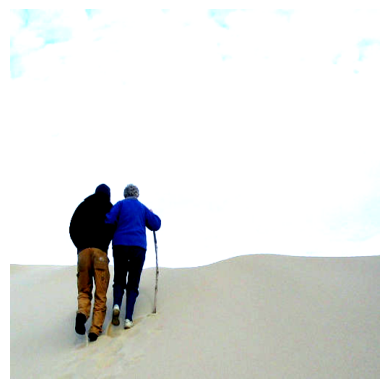

Cartoonized Image:


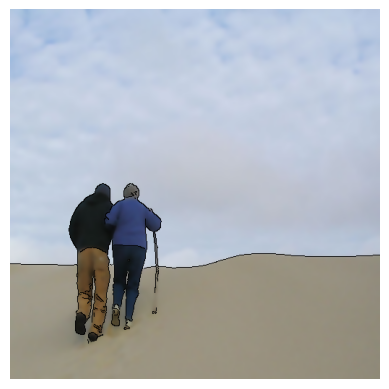

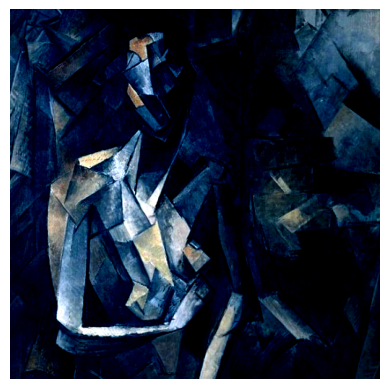

<ipython-input-93-35091fada221>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  content_encoder.load_state_dict(torch.load(best_content_encoder_path))
<ipython-input-93-35

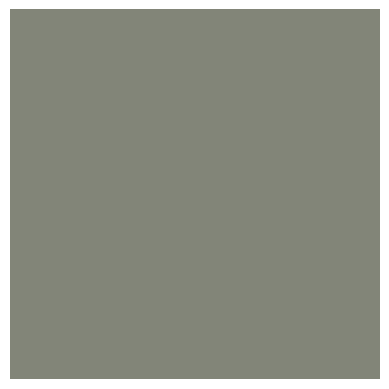

('/content/drive/MyDrive/ML Project/cartoon_output.jpg',
 '/content/drive/MyDrive/ML Project/stylized_output.jpg')

In [93]:
import torch
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

def cartoon_and_style_transfer(original_image_path, style_image_path, cartoon_output_path, style_output_path, best_weights_dir):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    def load_image(image_path):
        image = Image.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0).cuda()

    def process_image(image_path):
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")
        img = cv2.imread(image_path)

        if img is None:
            raise IOError(f"Unable to load image from: {image_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (512, 512))

        gray_img = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray_img, 100, 200)

        filtered_img = cv2.bilateralFilter(img_resized, d=9, sigmaColor=75, sigmaSpace=75)

        cartoon_img = cv2.bitwise_and(filtered_img, filtered_img, mask=~edges)

        return cartoon_img


    def save_and_show_image(tensor, filename):
        if len(tensor.shape) == 4:
            tensor = tensor.squeeze(0)
        if tensor.shape[0] == 3:
            tensor = tensor.permute(1, 2, 0)

        image = tensor.cpu().detach().numpy() * 0.5 + 0.5
        image = (image * 255).clip(0, 255).astype('uint8')
        cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

        plt.imshow(image)
        plt.axis('off')
        plt.show()

    content_image = load_image(original_image_path)
    save_and_show_image(content_image, cartoon_output_path)


    cartoon_image = process_image(original_image_path)
    cv2.imwrite(cartoon_output_path, cv2.cvtColor(cartoon_image, cv2.COLOR_RGB2BGR))
    print("Cartoonized Image:")
    plt.imshow(cartoon_image)
    plt.axis('off')
    plt.show()

    cartoon_pil = Image.fromarray(cartoon_image)
    cartoon_tensor = transform(cartoon_pil).unsqueeze(0).cuda()


    style_image = load_image(style_image_path)
    save_and_show_image(style_image, style_output_path)


    content_features, style_features = vgg_style_encoder()
    content_features = content_features.cuda().eval()
    style_features = style_features.cuda().eval()
    content_encoder, decoder = style_transfer_net()
    content_encoder = content_encoder.cuda().eval()
    decoder = decoder.cuda().eval()

    best_content_encoder_path = os.path.join(best_weights_dir, "best_content_encoder.pth")
    best_decoder_path = os.path.join(best_weights_dir, "best_decoder.pth")

    if not os.path.exists(best_content_encoder_path):
        raise FileNotFoundError(f"Best content encoder weights not found at: {best_content_encoder_path}")

    if not os.path.exists(best_decoder_path):
        raise FileNotFoundError(f"Best decoder weights not found at: {best_decoder_path}")

    content_encoder.load_state_dict(torch.load(best_content_encoder_path))
    decoder.load_state_dict(torch.load(best_decoder_path))

    content_features = content_encoder(cartoon_tensor)
    style_features = style_features(style_image)
    fused_features = cross_fusion_attention(content_features, style_features)
    final_image = decoder(fused_features)

    save_and_show_image(final_image, style_output_path)

    return cartoon_output_path, style_output_path

cartoon_and_style_transfer(
    original_image_path='/content/drive/MyDrive/STYLE TRANSFER dataset/dataset/dataset/15308698.jpg',
    style_image_path='/content/drive/MyDrive/STYLE TRANSFER dataset/style_data/class/style4.jpeg',
    cartoon_output_path='/content/drive/MyDrive/ML Project/cartoon_output.jpg',
    style_output_path='/content/drive/MyDrive/ML Project/stylized_output.jpg',
    best_weights_dir='/content/best_weights'
)
